In [1]:
!pip install torch==1.8.1

     |█▋                              | 41.6MB 3.9MB/s eta 0:03:17ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 382, in run
    resolver.resolve(requirement_set)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 201, in resolve
    self._resolve_one(requirement_set, req)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 365, in _resolve_one
    abstract_dist = self._get_abstract_dist_for(req_to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 313, in _get_abstract_dist_for
    req, self.session, self.finder, self.require_hashes
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/operations/prepare.py", line 194, in prepare_linked_r

In [2]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.2MB/s 
     |████████████████████████████████| 3.3MB 38.6MB/s 
     |████████████████████████████████| 901kB 35.2MB/s 


In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/Projects/Machine Learning/IMDB/imdb_sup.csv')
df

,Review,Rating,Sentiment
0,"Kurt Russell's chameleon-like performance, cou...",10,1
1,It was extremely low budget(it some scenes it ...,8,1
2,James Cagney is best known for his tough chara...,8,1
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,1
4,One of the last classics of the French New Wav...,10,1
...,...,...,...
49995,(spoiler) it could be the one the worst movie ...,4,0
49996,"So, you've seen the Romero movies, yes? And yo...",1,0
49997,Just listen to the Broadway cast album and to ...,3,0
49998,I have been a fan of the Carpenters for a long...,3,0


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [6]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [7]:
tokens = tokenizer.encode('It was good but couldve been better. Great', return_tensors='pt')

In [8]:
result = model(tokens)

In [9]:
result.logits

tensor([[-2.7768, -1.2353,  1.4419,  1.9804,  0.4584]],
       grad_fn=<AddmmBackward>)

In [12]:
int(torch.argmax(result.logits))+1

4

In [14]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [64]:
# Random 100 reviews from data frame
df_test_reviews = df.sample(n=1000)
df_test_reviews

,Review,Rating,Sentiment
22507,- Let me start by saying that I understand tha...,1,0
20843,Average (and surprisingly tame) Fulci giallo w...,3,0
41642,I was shocked there were 18 pages of good revi...,1,0
34237,"Back in the 60's, this grim study of Joy, a yo...",10,1
32751,"Focus is an engaging story told in urban, WWII...",7,1
...,...,...,...
21262,"I was really looking forward to watching this,...",3,0
13701,"Before I start, let me say that my experience ...",2,0
14162,"Noting the cast, I recently watched this movie...",4,0
29399,This DVD set is the complete widescreen 15-epi...,7,1


In [65]:
# 8:41 min for 1000 reviews.
pred_ratings = []
for i in df_test_reviews.iloc[:, 0]:
  pred_ratings.append(sentiment_score(i[:512]))

In [66]:
df_test_reviews["Sentiment_Score"] = pred_ratings

In [67]:
df_test_reviews

,Review,Rating,Sentiment,Sentiment_Score
22507,- Let me start by saying that I understand tha...,1,0,2
20843,Average (and surprisingly tame) Fulci giallo w...,3,0,3
41642,I was shocked there were 18 pages of good revi...,1,0,1
34237,"Back in the 60's, this grim study of Joy, a yo...",10,1,4
32751,"Focus is an engaging story told in urban, WWII...",7,1,4
...,...,...,...,...
21262,"I was really looking forward to watching this,...",3,0,2
13701,"Before I start, let me say that my experience ...",2,0,2
14162,"Noting the cast, I recently watched this movie...",4,0,2
29399,This DVD set is the complete widescreen 15-epi...,7,1,4


In [68]:
df_test_reviews["Rating"].replace({1: 1, 2: 1, 3: 2, 4: 2, 7: 4, 8: 4, 9: 5, 10: 5}, inplace=True)
df_test_reviews

,Review,Rating,Sentiment,Sentiment_Score
22507,- Let me start by saying that I understand tha...,1,0,2
20843,Average (and surprisingly tame) Fulci giallo w...,2,0,3
41642,I was shocked there were 18 pages of good revi...,1,0,1
34237,"Back in the 60's, this grim study of Joy, a yo...",5,1,4
32751,"Focus is an engaging story told in urban, WWII...",4,1,4
...,...,...,...,...
21262,"I was really looking forward to watching this,...",2,0,2
13701,"Before I start, let me say that my experience ...",1,0,2
14162,"Noting the cast, I recently watched this movie...",2,0,2
29399,This DVD set is the complete widescreen 15-epi...,4,1,4


# Confusion Matrics

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


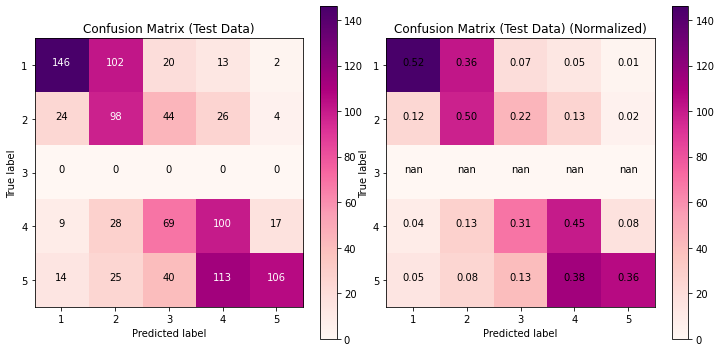

In [70]:
cm = confusion_matrix(df_test_reviews['Rating'], df_test_reviews["Sentiment_Score"])

plt.figure(figsize=(20,5))
plt.subplot(141)
plot_confusion_matrix(cm, classes=[1,2,3,4,5], normalize= False, title='Confusion Matrix (Test Data)', cmap='RdPu')
plt.subplot(142)
plot_confusion_matrix(cm, classes=[1,2,3,4,5], normalize= True, title='Confusion Matrix (Test Data) (Normalized)', cmap='RdPu')

In [71]:
from sklearn.metrics import classification_report

print(classification_report(df_test_reviews["Sentiment_Score"], df_test_reviews['Rating']))

              precision    recall  f1-score   support

           1       0.52      0.76      0.61       193
           2       0.50      0.39      0.44       253
           3       0.00      0.00      0.00       173
           4       0.45      0.40      0.42       252
           5       0.36      0.82      0.50       129

    accuracy                           0.45      1000
   macro avg       0.36      0.47      0.39      1000
weighted avg       0.38      0.45      0.40      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
